---

Vectorized slicing
chỉ áp dụng Scheduled Sampling 1 phần nhỏ dữ liệu

---

7262/7262 ━━━━━━━━━━━━━━━━━━━━ 1146s 157ms/step - loss: 0.1007 - val_loss: 0.0131
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 1085s 149ms/step - loss: 0.0128 - val_loss: 0.0069
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 1085s 149ms/step - loss: 0.0109 - val_loss: 0.0055
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 1063s 146ms/step - loss: 0.0097 - val_loss: 0.0027
Epoch 4: reducing learning rate to 0.000500
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 1058s 146ms/step - loss: 0.0073 - val_loss: 0.0038
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 1059s 146ms/step - loss: 0.0075 - val_loss: 0.0028
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 1066s 147ms/step - loss: 0.0073 - val_loss: 0.0025
Epoch 7: reducing learning rate to 0.000250
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 1073s 148ms/step - loss: 0.0066 - val_loss: 0.0016
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 1095s 151ms/step - loss: 0.0064 - val_loss: 0.0016
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 1050s 145ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 10: reducing learning rate to 0.000125
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 1045s 144ms/step

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/vali

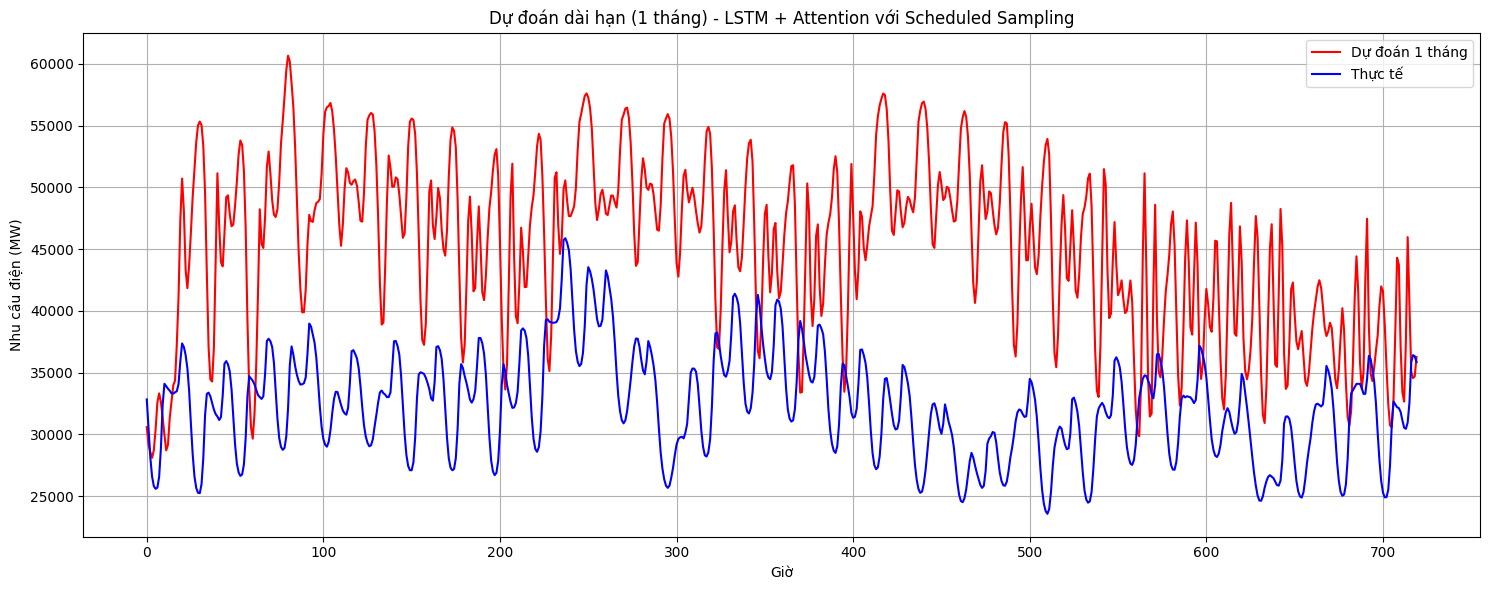

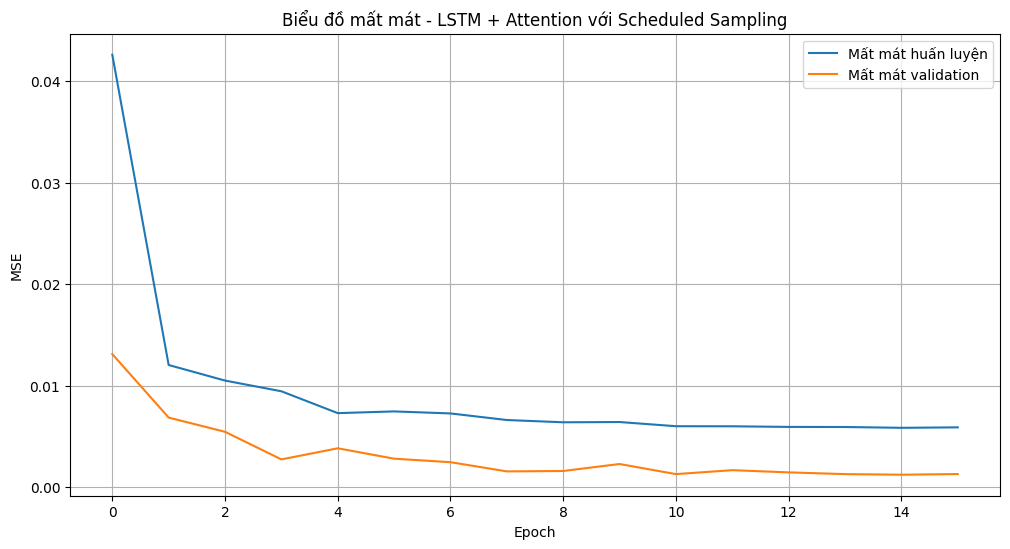

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, MultiHeadAttention, LayerNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Đọc và tiền xử lý dữ liệu
df = pd.read_csv('data/PJME_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime').sort_index()
df = df.resample('h').mean()
df['PJME_MW'] = df['PJME_MW'].interpolate(method='time')

# Thêm đặc trưng tuần hoàn
df_features = df.copy()
df_features['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
df_features['day_sin'] = np.sin(2 * np.pi * df.index.day / 30)
df_features['day_cos'] = np.cos(2 * np.pi * df.index.day / 30)
df_features['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
df_features['season'] = ((df.index.month % 12) // 3).map({0: 0, 1: 1, 2: 2, 3: 3})
df_features['day_of_week'] = df.index.dayofweek
df_features['day_of_week_sin'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
df_features['day_of_week_cos'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
df_features['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

# Hàm tạo đặc trưng
def feature_engineering_pipe(df, target_column):
    df = df.copy()
    for lag in [24, 168, 720]:
        df[f'lag_{lag}h'] = df[target_column].shift(lag)
        df[f'lag_diff_{lag}h'] = df[target_column] - df[f'lag_{lag}h']
    for window in [24, 720]:
        df[f'rolling_mean_{window}h'] = df[target_column].rolling(window=window).mean()
        df[f'rolling_std_{window}h'] = df[target_column].rolling(window=window).std()
        df[f'rolling_min_{window}h'] = df[target_column].rolling(window=window).min()
        df[f'rolling_max_{window}h'] = df[target_column].rolling(window=window).max()
    return df

# Hàm xử lý giá trị NaN
def fillna_pipe(df):
    df = df.copy()

    for col in df.columns:
        if col.startswith('lag_') or col.startswith('lag_diff_'):
            df[col] = df.groupby(df.index.hour)[col].transform(lambda x: x.fillna(x.mean()))

    for window in [24, 720]:
        mask = df[f'rolling_mean_{window}h'].isna()
        df.loc[mask, f'rolling_mean_{window}h'] = df.loc[mask, 'PJME_MW']
        df[f'rolling_std_{window}h'] = df[f'rolling_std_{window}h'].fillna(0)
        df.loc[mask, f'rolling_min_{window}h'] = df.loc[mask, 'PJME_MW']
        df.loc[mask, f'rolling_max_{window}h'] = df.loc[mask, 'PJME_MW']
    return df

df_features = feature_engineering_pipe(df_features, 'PJME_MW')
df_features = fillna_pipe(df_features)

# Chuẩn hóa dữ liệu
scaler_target = StandardScaler()
scaler_features = MinMaxScaler()

scaled_target = scaler_target.fit_transform(df_features[['PJME_MW']])

features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'season',
    'day_of_week_sin', 'day_of_week_cos', 'is_weekend',
    'lag_24h', 'lag_168h', 'lag_720h', 'lag_diff_24h', 'lag_diff_168h', 'lag_diff_720h',
    'rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h',
    'rolling_mean_720h', 'rolling_std_720h', 'rolling_min_720h', 'rolling_max_720h'
]

scaled_features = scaler_features.fit_transform(df_features[features])
data = np.hstack((scaled_target, scaled_features))

# Tạo sequences
def create_sequences_with_features(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 168
X, y = create_sequences_with_features(data, seq_length)

# Chia tập dữ liệu
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train = X[:train_size]
X_val = X[train_size:train_size + val_size]
X_test = X[train_size + val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size + val_size]
y_test = y[train_size + val_size:]

test_dates = df.index[train_size + val_size + seq_length:]

# Xây dựng mô hình LSTM + Attention
def build_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(128, activation='tanh', return_sequences=True)(inputs)
    lstm_out = LayerNormalization()(lstm_out)

    attention = MultiHeadAttention(num_heads=5, key_dim=32)(lstm_out, lstm_out)
    attention = LayerNormalization()(attention + lstm_out)

    lstm_out2 = LSTM(64, activation='tanh', return_sequences=True)(attention)
    lstm_out2 = LayerNormalization()(lstm_out2)
    lstm_out3 = LSTM(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001))(lstm_out2)

    outputs = Dense(64, activation='relu')(lstm_out3)
    outputs = Dropout(0.1)(outputs)
    outputs = Dense(1)(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Custom EarlyStopping
class CustomEarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = np.inf
        self.stopped_epoch = 0
        self.stop_training = False
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

    def on_epoch_end(self, epoch, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.stop_training = True
                print(f"Early stopping at epoch {epoch + 1}")
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.set_weights(self.best_weights)

    def set_model(self, model):
        self.model = model

# Custom ReduceLROnPlateau
class CustomReduceLROnPlateau:
    def __init__(self, model, patience=3, factor=0.2, min_lr=1e-4):
        self.model = model
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.best_metric = -np.inf
        self.wait = 0

    def on_epoch_end(self, epoch, current_metric):
        if current_metric > self.best_metric:
            self.best_metric = current_metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                lr = float(self.model.optimizer.learning_rate)
                new_lr = max(lr - self.factor * lr, self.min_lr)
                self.model.optimizer.learning_rate = new_lr
                print(f"Epoch {epoch + 1}: reducing learning rate to {new_lr:.6f}")
                self.wait = 0

# Hàm Scheduled Sampling
def scheduled_sampling(model, X, y, X_val, y_val, epochs, batch_size=16, scheduled_sample_ratio=0.4, initial_teacher_forcing_ratio=0.99):
    np.random.seed(42)
    
    history = {'loss': [], 'val_loss': []}
    early_stop = CustomEarlyStopping(patience=5, min_delta=1e-4)
    early_stop.set_model(model)
    reduce_lr = CustomReduceLROnPlateau(model, patience=3, factor=0.5)

    for epoch in range(epochs):
        tf_ratio = initial_teacher_forcing_ratio * (1 - epoch / epochs)
        X_epoch = X.copy()

        total_samples = len(X)
        num_samples_to_apply = int(total_samples * scheduled_sample_ratio)
        candidate_indices = np.random.choice(total_samples, size=num_samples_to_apply, replace=False)

        preds = model.predict(X, verbose=0, batch_size=batch_size).reshape(-1)

        rand_mask = np.random.rand(num_samples_to_apply) > tf_ratio
        sampled_indices = candidate_indices[rand_mask]
        valid_indices = sampled_indices[sampled_indices > 0]

        if len(valid_indices) > 0:
            X_epoch[valid_indices, -1, 0] = preds[valid_indices - 1]

        X_epoch[valid_indices, -1, 0] = preds[valid_indices - 1]

        hist = model.fit(
            X_epoch, y,
            epochs=1,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=1
        )

        loss = hist.history['loss'][0]
        val_loss = hist.history['val_loss'][0]
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)

        reduce_lr.on_epoch_end(epoch, val_loss)
        early_stop.on_epoch_end(epoch, val_loss)
        if early_stop.stop_training:
            break

    return history

# Hàm dự đoán truy hồi
def recursive_forecast(model, initial_sequence, steps, scaler_target, scaler_features, features):
    sequence = initial_sequence.copy()
    forecasts = []

    hour_angle = np.arctan2(initial_sequence[0, 1], initial_sequence[0, 2])
    initial_hour = (hour_angle % (2 * np.pi)) * 24 / (2 * np.pi)

    day_angle = np.arctan2(initial_sequence[0, 3], initial_sequence[0, 4])
    initial_day = (day_angle % (2 * np.pi)) * 30 / (2 * np.pi)

    month_angle = np.arctan2(initial_sequence[0, 5], initial_sequence[0, 6])
    initial_month = (month_angle % (2 * np.pi)) * 12 / (2 * np.pi)

    history = scaler_target.inverse_transform(sequence[:, 0].reshape(-1, 1)).flatten().tolist()

    for i in range(steps):
        pred = model.predict(sequence[np.newaxis, :, :], verbose=0)
        pred_scaled = pred[0, 0]
        pred_inv = scaler_target.inverse_transform([[pred_scaled]])[0, 0]

        forecasts.append(pred_inv)
        history.append(pred_inv)

        sequence = np.roll(sequence, -1, axis=0)
        sequence[-1, 0] = pred_scaled

        current_hour = (initial_hour + i) % 24
        current_day = (initial_day + i // 24) % 30
        current_month = (initial_month + i // (24 * 30)) % 12

        sequence[-1, 1] = np.sin(2 * np.pi * current_hour / 24)
        sequence[-1, 2] = np.cos(2 * np.pi * current_hour / 24)
        sequence[-1, 3] = np.sin(2 * np.pi * current_day / 30)
        sequence[-1, 4] = np.cos(2 * np.pi * current_day / 30)
        sequence[-1, 5] = np.sin(2 * np.pi * current_month / 12)
        sequence[-1, 6] = np.cos(2 * np.pi * current_month / 12)
        sequence[-1, 7] = ((current_month % 12) // 3)

        current_day_of_week = ((df.index[-1].dayofweek + i // 24) % 7)
        sequence[-1, 8] = np.sin(2 * np.pi * current_day_of_week / 7)
        sequence[-1, 9] = np.cos(2 * np.pi * current_day_of_week / 7)
        sequence[-1, 10] = 1 if current_day_of_week in [5, 6] else 0

        for lag, idx in zip([24, 168, 720], [11, 12, 13]):
            if len(history) >= lag:
                lag_value = history[-lag]
                sequence[-1, idx] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], lag_value, sequence[-1, 12], sequence[-1, 13], sequence[-1, 14], sequence[-1, 15], sequence[-1, 16], sequence[-1, 17], sequence[-1, 18], sequence[-1, 19], sequence[-1, 20], sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx - 1]

        for lag, idx in zip([24, 168, 720], [14, 15, 16]):
            if len(history) >= lag:
                lag_value = history[-lag]
                lag_diff_value = history[-1] - lag_value
                sequence[-1, idx] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], sequence[-1, 11], sequence[-1, 12], sequence[-1, 13], lag_diff_value, sequence[-1, 15], sequence[-1, 16], sequence[-1, 17], sequence[-1, 18], sequence[-1, 19], sequence[-1, 20], sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx - 1]

        for window, idx in zip([24, 720], [(17, 18, 19, 20), (21, 22, 23, 24)]):
            if len(history) >= window:
                window_data = history[-window:]
                sequence[-1, idx[0]] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], sequence[-1, 11], sequence[-1, 12], sequence[-1, 13], sequence[-1, 14], sequence[-1, 15], sequence[-1, 16], np.mean(window_data), sequence[-1, 18], sequence[-1, 19], sequence[-1, 20], sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx[0] - 1]
                sequence[-1, idx[1]] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], sequence[-1, 11], sequence[-1, 12], sequence[-1, 13], sequence[-1, 14], sequence[-1, 15], sequence[-1, 16], sequence[-1, 17], np.std(window_data), sequence[-1, 19], sequence[-1, 20], sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx[1] - 1]
                sequence[-1, idx[2]] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], sequence[-1, 11], sequence[-1, 12], sequence[-1, 13], sequence[-1, 14], sequence[-1, 15], sequence[-1, 16], sequence[-1, 17], sequence[-1, 18], np.min(window_data), sequence[-1, 20], sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx[2] - 1]
                sequence[-1, idx[3]] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], sequence[-1, 11], sequence[-1, 12], sequence[-1, 13], sequence[-1, 14], sequence[-1, 15], sequence[-1, 16], sequence[-1, 17], sequence[-1, 18], sequence[-1, 19], np.max(window_data), sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx[3] - 1]

    return np.array(forecasts).reshape(-1, 1)

# Huấn luyện mô hình
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_attention_model(input_shape)

history = scheduled_sampling(model, X_train, y_train, X_val, y_val, epochs=50)

# Dự đoán trên tập test
y_pred = model.predict(X_test, verbose=0)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Đánh giá
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

print("\nKết quả đánh giá LSTM + Attention với Scheduled Sampling:")
print(f"MAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

# Dự đoán dài hạn (1 tháng)
initial_sequence = X_test[8112]
long_term_pred = recursive_forecast(model, initial_sequence, steps=720, scaler_target=scaler_target, 
                                    scaler_features=scaler_features, features=features)

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
plt.plot(long_term_pred, label='Dự đoán 1 tháng', color='red')
plt.plot(y_test_inv[:720], label='Thực tế', color='blue')
plt.title('Dự đoán dài hạn (1 tháng) - LSTM + Attention với Scheduled Sampling')
plt.xlabel('Giờ')
plt.ylabel('Nhu cầu điện (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Mất mát huấn luyện')
plt.plot(history['val_loss'], label='Mất mát validation')
plt.title('Biểu đồ mất mát - LSTM + Attention với Scheduled Sampling')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

---

7262/7262 ━━━━━━━━━━━━━━━━━━━━ 643s 88ms/step - loss: 0.0978 - val_loss: 0.0130
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 623s 86ms/step - loss: 0.0201 - val_loss: 0.0049
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 621s 85ms/step - loss: 0.0181 - val_loss: 0.0079
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 617s 85ms/step - loss: 0.0170 - val_loss: 0.0040
Epoch 4: reducing learning rate to 0.000500
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 602s 83ms/step - loss: 0.0140 - val_loss: 0.0057
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 620s 85ms/step - loss: 0.0139 - val_loss: 0.0030
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 622s 86ms/step - loss: 0.0137 - val_loss: 0.0030
Epoch 7: reducing learning rate to 0.000250
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 625s 86ms/step - loss: 0.0128 - val_loss: 0.0024
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 696s 96ms/step - loss: 0.0127 - val_loss: 0.0019
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 629s 87ms/step - loss: 0.0126 - val_loss: 0.0018
Epoch 10: reducing learning rate to 0.000125
7262/7262 ━━━━━━━━━━━━━━━━━━━━ 610s 84ms/step - loss: 0.0122 - val_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/vali

Step 4: pred_scaled = -1.0522, pred_inv = 25277.16 MW
Step 5: pred_scaled = -0.9398, pred_inv = 26003.96 MW


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/vali

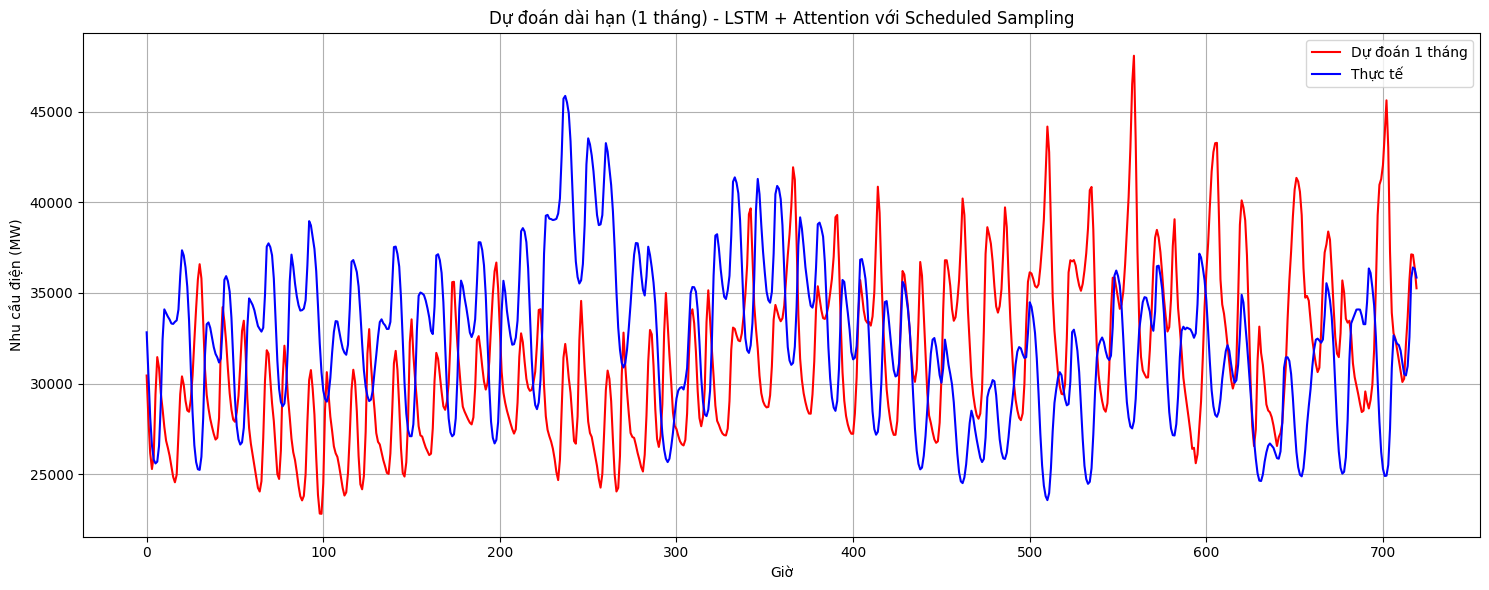

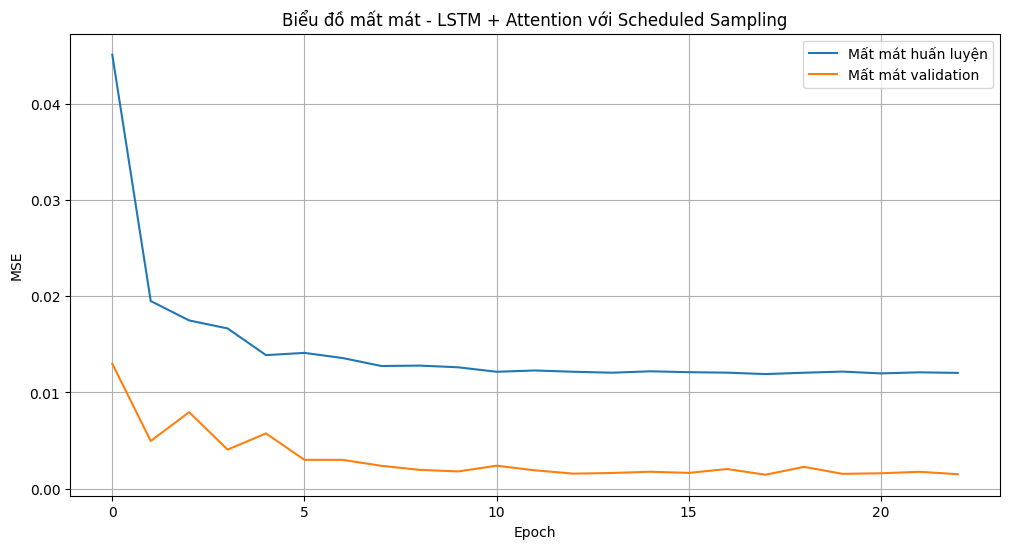

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, MultiHeadAttention, LayerNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Đọc và tiền xử lý dữ liệu
df = pd.read_csv('data/PJME_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime').sort_index()
df = df.resample('h').mean()
df['PJME_MW'] = df['PJME_MW'].interpolate(method='time')

# Thêm đặc trưng tuần hoàn
df_features = df.copy()
df_features['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
df_features['day_sin'] = np.sin(2 * np.pi * df.index.day / 30)
df_features['day_cos'] = np.cos(2 * np.pi * df.index.day / 30)
df_features['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
df_features['season'] = ((df.index.month % 12) // 3).map({0: 0, 1: 1, 2: 2, 3: 3})
df_features['day_of_week'] = df.index.dayofweek
df_features['day_of_week_sin'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
df_features['day_of_week_cos'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
df_features['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

# Hàm tạo đặc trưng
def feature_engineering_pipe(df, target_column):
    df = df.copy()
    for lag in [24, 168, 720]:
        df[f'lag_{lag}h'] = df[target_column].shift(lag)
        df[f'lag_diff_{lag}h'] = df[target_column] - df[f'lag_{lag}h']
    for window in [24, 720]:
        df[f'rolling_mean_{window}h'] = df[target_column].rolling(window=window).mean()
        df[f'rolling_std_{window}h'] = df[target_column].rolling(window=window).std()
        df[f'rolling_min_{window}h'] = df[target_column].rolling(window=window).min()
        df[f'rolling_max_{window}h'] = df[target_column].rolling(window=window).max()
    return df

# Hàm xử lý giá trị NaN
def fillna_pipe(df):
    df = df.copy()

    for col in df.columns:
        if col.startswith('lag_') or col.startswith('lag_diff_'):
            df[col] = df.groupby(df.index.hour)[col].transform(lambda x: x.fillna(x.mean()))

    for window in [24, 720]:
        mask = df[f'rolling_mean_{window}h'].isna()
        df.loc[mask, f'rolling_mean_{window}h'] = df.loc[mask, 'PJME_MW']
        df[f'rolling_std_{window}h'] = df[f'rolling_std_{window}h'].fillna(0)
        df.loc[mask, f'rolling_min_{window}h'] = df.loc[mask, 'PJME_MW']
        df.loc[mask, f'rolling_max_{window}h'] = df.loc[mask, 'PJME_MW']
    return df

df_features = feature_engineering_pipe(df_features, 'PJME_MW')
df_features = fillna_pipe(df_features)

# Chuẩn hóa dữ liệu
scaler_target = StandardScaler()
scaler_features = MinMaxScaler()

scaled_target = scaler_target.fit_transform(df_features[['PJME_MW']])

features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'season',
    'day_of_week_sin', 'day_of_week_cos', 'is_weekend',
    'lag_24h', 'lag_168h', 'lag_720h', 'lag_diff_24h', 'lag_diff_168h', 'lag_diff_720h',
    'rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h',
    'rolling_mean_720h', 'rolling_std_720h', 'rolling_min_720h', 'rolling_max_720h'
]

scaled_features = scaler_features.fit_transform(df_features[features])
data = np.hstack((scaled_target, scaled_features))

# Tạo sequences
def create_sequences_with_features(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 168
X, y = create_sequences_with_features(data, seq_length)

# Chia tập dữ liệu
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train = X[:train_size]
X_val = X[train_size:train_size + val_size]
X_test = X[train_size + val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size + val_size]
y_test = y[train_size + val_size:]

test_dates = df.index[train_size + val_size + seq_length:]

# Xây dựng mô hình LSTM + Attention
def build_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(64, activation='tanh', return_sequences=True)(inputs)
    lstm_out = LayerNormalization()(lstm_out)

    attention = MultiHeadAttention(num_heads=3, key_dim=32)(lstm_out, lstm_out)
    attention = LayerNormalization()(attention + lstm_out)

    lstm_out2 = LSTM(32, activation='tanh', return_sequences=True)(attention)
    lstm_out2 = LayerNormalization()(lstm_out2)
    lstm_out3 = LSTM(32, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001))(lstm_out2)

    outputs = Dense(64, activation='relu')(lstm_out3)
    outputs = Dropout(0.2)(outputs)
    outputs = Dense(1)(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Custom EarlyStopping
class CustomEarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = np.inf
        self.stopped_epoch = 0
        self.stop_training = False
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

    def on_epoch_end(self, epoch, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.stop_training = True
                print(f"Early stopping at epoch {epoch + 1}")
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.set_weights(self.best_weights)

    def set_model(self, model):
        self.model = model

# Custom ReduceLROnPlateau
class CustomReduceLROnPlateau:
    def __init__(self, model, patience=3, factor=0.2, min_lr=1e-4):
        self.model = model
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.best_metric = -np.inf
        self.wait = 0

    def on_epoch_end(self, epoch, current_metric):
        if current_metric > self.best_metric:
            self.best_metric = current_metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                lr = float(self.model.optimizer.learning_rate)
                new_lr = max(lr - self.factor * lr, self.min_lr)
                self.model.optimizer.learning_rate = new_lr
                print(f"Epoch {epoch + 1}: reducing learning rate to {new_lr:.6f}")
                self.wait = 0

# Hàm Scheduled Sampling
def scheduled_sampling(model, X, y, X_val, y_val, epochs, batch_size=16, scheduled_sample_ratio=0.2, initial_teacher_forcing_ratio=0.99):
    np.random.seed(42)
    
    history = {'loss': [], 'val_loss': []}
    early_stop = CustomEarlyStopping(patience=5, min_delta=1e-4)
    early_stop.set_model(model)
    reduce_lr = CustomReduceLROnPlateau(model, patience=3, factor=0.5)

    for epoch in range(epochs):
        tf_ratio = initial_teacher_forcing_ratio * (1 - epoch / epochs)
        X_epoch = X.copy()

        total_samples = len(X)
        num_samples_to_apply = int(total_samples * scheduled_sample_ratio)
        candidate_indices = np.random.choice(total_samples, size=num_samples_to_apply, replace=False)

        preds = model.predict(X, verbose=0, batch_size=batch_size).reshape(-1)
        noise = np.random.normal(0.005, 0.005, size=preds.shape)  # Thêm nhiễu với trung bình dương
        preds += noise

        rand_mask = np.random.rand(num_samples_to_apply) > tf_ratio
        sampled_indices = candidate_indices[rand_mask]
        valid_indices = sampled_indices[sampled_indices > 0]

        if len(valid_indices) > 0:
            X_epoch[valid_indices, -1, 0] = preds[valid_indices - 1]

        X_epoch[valid_indices, -1, 0] = preds[valid_indices - 1]

        hist = model.fit(
            X_epoch, y,
            epochs=1,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=1
        )

        loss = hist.history['loss'][0]
        val_loss = hist.history['val_loss'][0]
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)

        reduce_lr.on_epoch_end(epoch, val_loss)
        early_stop.on_epoch_end(epoch, val_loss)
        if early_stop.stop_training:
            break

    return history

# Hàm dự đoán truy hồi
def recursive_forecast(model, initial_sequence, steps, scaler_target, scaler_features, features):
    sequence = initial_sequence.copy()
    forecasts = []

    hour_angle = np.arctan2(initial_sequence[0, 1], initial_sequence[0, 2])
    initial_hour = (hour_angle % (2 * np.pi)) * 24 / (2 * np.pi)

    day_angle = np.arctan2(initial_sequence[0, 3], initial_sequence[0, 4])
    initial_day = (day_angle % (2 * np.pi)) * 30 / (2 * np.pi)

    month_angle = np.arctan2(initial_sequence[0, 5], initial_sequence[0, 6])
    initial_month = (month_angle % (2 * np.pi)) * 12 / (2 * np.pi)

    history = scaler_target.inverse_transform(sequence[:, 0].reshape(-1, 1)).flatten().tolist()

    for i in range(steps):
        pred = model.predict(sequence[np.newaxis, :, :], verbose=0)
        pred_scaled = pred[0, 0]
        pred_inv = scaler_target.inverse_transform([[pred_scaled]])[0, 0]

        # Kiểm tra giá trị dự đoán
        if i < 5:  # In 5 giá trị đầu tiên để kiểm tra
            print(f"Step {i+1}: pred_scaled = {pred_scaled:.4f}, pred_inv = {pred_inv:.2f} MW")

        forecasts.append(pred_inv)
        history.append(pred_inv)

        sequence = np.roll(sequence, -1, axis=0)
        sequence[-1, 0] = pred_scaled

        current_hour = (initial_hour + i) % 24
        current_day = (initial_day + i // 24) % 30
        current_month = (initial_month + i // (24 * 30)) % 12

        sequence[-1, 1] = np.sin(2 * np.pi * current_hour / 24)
        sequence[-1, 2] = np.cos(2 * np.pi * current_hour / 24)
        sequence[-1, 3] = np.sin(2 * np.pi * current_day / 30)
        sequence[-1, 4] = np.cos(2 * np.pi * current_day / 30)
        sequence[-1, 5] = np.sin(2 * np.pi * current_month / 12)
        sequence[-1, 6] = np.cos(2 * np.pi * current_month / 12)
        sequence[-1, 7] = ((current_month % 12) // 3)

        current_day_of_week = ((df.index[-1].dayofweek + i // 24) % 7)
        sequence[-1, 8] = np.sin(2 * np.pi * current_day_of_week / 7)
        sequence[-1, 9] = np.cos(2 * np.pi * current_day_of_week / 7)
        sequence[-1, 10] = 1 if current_day_of_week in [5, 6] else 0

        for lag, idx in zip([24, 168, 720], [11, 12, 13]):
            if len(history) >= lag:
                lag_value = history[-lag]
                sequence[-1, idx] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], lag_value, sequence[-1, 12], sequence[-1, 13], sequence[-1, 14], sequence[-1, 15], sequence[-1, 16], sequence[-1, 17], sequence[-1, 18], sequence[-1, 19], sequence[-1, 20], sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx - 1]

        for lag, idx in zip([24, 168, 720], [14, 15, 16]):
            if len(history) >= lag:
                lag_value = history[-lag]
                lag_diff_value = history[-1] - lag_value
                sequence[-1, idx] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], sequence[-1, 11], sequence[-1, 12], sequence[-1, 13], lag_diff_value, sequence[-1, 15], sequence[-1, 16], sequence[-1, 17], sequence[-1, 18], sequence[-1, 19], sequence[-1, 20], sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx - 1]

        for window, idx in zip([24, 720], [(17, 18, 19, 20), (21, 22, 23, 24)]):
            if len(history) >= window:
                window_data = history[-window:]
                sequence[-1, idx[0]] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], sequence[-1, 11], sequence[-1, 12], sequence[-1, 13], sequence[-1, 14], sequence[-1, 15], sequence[-1, 16], np.mean(window_data), sequence[-1, 18], sequence[-1, 19], sequence[-1, 20], sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx[0] - 1]
                sequence[-1, idx[1]] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], sequence[-1, 11], sequence[-1, 12], sequence[-1, 13], sequence[-1, 14], sequence[-1, 15], sequence[-1, 16], sequence[-1, 17], np.std(window_data), sequence[-1, 19], sequence[-1, 20], sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx[1] - 1]
                sequence[-1, idx[2]] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], sequence[-1, 11], sequence[-1, 12], sequence[-1, 13], sequence[-1, 14], sequence[-1, 15], sequence[-1, 16], sequence[-1, 17], sequence[-1, 18], np.min(window_data), sequence[-1, 20], sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx[2] - 1]
                sequence[-1, idx[3]] = scaler_features.transform([[sequence[-1, 1], sequence[-1, 2], sequence[-1, 3], sequence[-1, 4], sequence[-1, 5], sequence[-1, 6], sequence[-1, 7], sequence[-1, 8], sequence[-1, 9], sequence[-1, 10], sequence[-1, 11], sequence[-1, 12], sequence[-1, 13], sequence[-1, 14], sequence[-1, 15], sequence[-1, 16], sequence[-1, 17], sequence[-1, 18], sequence[-1, 19], np.max(window_data), sequence[-1, 21], sequence[-1, 22], sequence[-1, 23], sequence[-1, 24]]])[0, idx[3] - 1]

    return np.array(forecasts).reshape(-1, 1)

# Huấn luyện mô hình
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_attention_model(input_shape)

history = scheduled_sampling(model, X_train, y_train, X_val, y_val, epochs=50)

# Dự đoán trên tập test
y_pred = model.predict(X_test, verbose=0)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Đánh giá
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

print("\nKết quả đánh giá LSTM + Attention với Scheduled Sampling:")
print(f"MAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

# Dự đoán dài hạn (1 tháng)
initial_sequence = X_test[8112]
long_term_pred = recursive_forecast(model, initial_sequence, steps=720, scaler_target=scaler_target, 
                                    scaler_features=scaler_features, features=features)

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
plt.plot(long_term_pred, label='Dự đoán 1 tháng', color='red')
plt.plot(y_test_inv[:720], label='Thực tế', color='blue')
plt.title('Dự đoán dài hạn (1 tháng) - LSTM + Attention với Scheduled Sampling')
plt.xlabel('Giờ')
plt.ylabel('Nhu cầu điện (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Mất mát huấn luyện')
plt.plot(history['val_loss'], label='Mất mát validation')
plt.title('Biểu đồ mất mát - LSTM + Attention với Scheduled Sampling')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)